<a href="https://colab.research.google.com/github/elrichgro/irccam-pmodwrc/blob/main/irccam/notebooks/night_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Get code
%cd /content
!rm -rf irccam-pmodwrc/
!git clone https://github.com/elrichgro/irccam-pmodwrc.git

/content
Cloning into 'irccam-pmodwrc'...
remote: Enumerating objects: 136, done.
remote: Counting objects: 100% (136/136), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 811 (delta 77), reused 99 (delta 45), pack-reused 675
Receiving objects: 100% (811/811), 103.17 MiB | 32.89 MiB/s, done.
Resolving deltas: 100% (490/490), done.


In [ ]:
#  Mount data
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
requirements = """
torch
torchvision
tqdm
h5py
jupyterlab
opencv-contrib-python
opencv-python
pytorch-lightning==1.0.5
future==0.17.1
scipy
scikit-learn
astral
test-tube
pysolar
"""

with open('requirements.txt', 'w') as f:
  f.write(requirements)

!pip install -r requirements.txt

In [ ]:
%cd /content/irccam-pmodwrc/

/content/irccam-pmodwrc


In [ ]:
from irccam.training.cloud_segmentation import CloudSegmentation
from irccam.utils.constants import *
from irccam.datasets.cloud_dataset import HDF5Dataset
import torch
import matplotlib.pyplot as plt
import h5py
import cv2
import numpy as np
from tqdm.auto import tqdm
from torchvision import transforms
import matplotlib.gridspec as gridspec
%matplotlib inline

In [ ]:
checkpoint_path = "/content/drive/My Drive/dsl/training_logs/20201215152108-experiment_deeplab/tube_logs/version_0/checkpoints/best-epoch=12-val_iou=0.77.ckpt" # 3

In [ ]:
model = CloudSegmentation.load_from_checkpoint(checkpoint_path)

In [ ]:
trans = transforms.Compose([transforms.ToTensor(),])
test_data = HDF5Dataset("/content/drive/My Drive/dsl/datasets/optimized_3/", "test", trans, use_clear_sky=True, use_sun_mask=True)
test_data_no_sky = HDF5Dataset("/content/drive/My Drive/dsl/datasets/optimized_3/", "test", trans, use_clear_sky=False, use_sun_mask=False)
test_data_no_mask = HDF5Dataset("/content/drive/My Drive/dsl/datasets/optimized_3/", "test", trans, use_clear_sky=True, use_sun_mask=False)

In [ ]:
def get_vis_img(timestamp):
  file = "/content/drive/My Drive/dsl/datasets/main_3/{}.h5".format(timestamp[:8])
  with h5py.File(file, 'r') as f:
    idx = None
    for i, ts in enumerate(f['timestamp']):
      if timestamp[:12] in ts:
        idx = i
        break
    assert idx is not None, "Could not find image for timestamp {}".format(timestamp)
    return cv2.cvtColor(np.nan_to_num(f['vis'][idx], nan=255).astype(np.uint8), cv2.COLOR_BGR2RGB)

In [ ]:
from irccam.datasets.create_dataset import convert_timestamp
from irccam.datasets.preprocessing import process_irccam_img

def get_irc_img(timestamp):
  file = "/content/drive/My Drive/dsl/irccam/irccam_{}_rad.mat".format(timestamp[:8])
  with h5py.File(file, 'r') as f:
    idx = None
    for i, ts in enumerate(f['TM'][0]):
      if timestamp[:12] in convert_timestamp(timestamp[:8], ts).strftime('%Y%m%d%H%M'):
        idx = i
        break
    assert idx is not None, "Could not find image for timestamp {}".format(timestamp)
    return process_irccam_img(f['BT'][idx])


def get_clear_sky(timestamp):
  file = "/content/drive/My Drive/dsl/irccam/irccam_{}_rad.mat".format(timestamp[:8])
  with h5py.File(file, 'r') as f:
    idx = None
    for i, ts in enumerate(f['TM'][0]):
      if timestamp[:12] in convert_timestamp(timestamp[:8], ts).strftime('%Y%m%d%H%M'):
        idx = i
        break
    assert idx is not None, "Could not find image for timestamp {}".format(timestamp)
    return process_irccam_img(f['TB'][idx])

201805300500


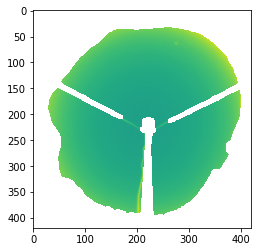

In [ ]:
idx = np.random.randint(0, len(test_data_no_mask))
time = np.random.randint(1, 6)
ts = test_data_no_mask[idx]['timestamp']
irc = get_irc_img('{}0100'.format(ts[:8]))
print('{}0{}00'.format(ts[:8], time))
plt.imshow(irc)

In [ ]:
timestamps = [
  '201810070100',
  '201812070100',
  '201809090100',
  '201807100100',
  '201805030400', # ?
  '201807050100',
  '201810040400'
]

In [ ]:
# Plot results
def plot_ax(gs, img):
  ax = plt.subplot(gs)
  plt.axis('off')
  ax.set_xticklabels([])
  ax.set_yticklabels([])
  ax.imshow(img)

def plot_results(results):
  dim_size = 5
  rows = len(results)
  cols = len(results[0])
  plt.figure(figsize = (dim_size*cols,dim_size*rows))
  gs = gridspec.GridSpec(rows, cols)
  gs.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

  for i in range(rows):
    for j in range(cols):
      plot_ax(gs[i*cols+j], results[i][j])

  plt.show()

def save_results(results, filename):
  dim_size = 5
  rows = len(results)
  cols = len(results[0])
  plt.figure(figsize = (dim_size*cols,dim_size*rows))
  gs = gridspec.GridSpec(rows, cols)
  gs.update(wspace=0.025, hspace=0.05) # set the spacing between axes. 

  for i in range(rows):
    for j in range(cols):
      plot_ax(gs[i*cols+j], results[i][j])

  plt.gca().set_axis_off()
  plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0, 
              hspace = 0, wspace = 0)
  plt.margins(0,0)
  plt.gca().xaxis.set_major_locator(plt.NullLocator())
  plt.gca().yaxis.set_major_locator(plt.NullLocator())
  plt.savefig(filename, bbox_inches = 'tight', pad_inches = 0)
  plt.close()

In [ ]:
from irccam.datasets.preprocessing import process_irccam_img
from irccam.datasets.create_dataset import convert_timestamp

def get_pmod_label(timestamp):
  day = timestamp[:8]
  file = "/content/drive/My Drive/dsl/irccam/irccam_{}_rad.mat".format(day)
  with h5py.File(file, 'r') as f:
    idx = None
    for i, ts in enumerate(f['TM'][0]):
      if timestamp[:12] in convert_timestamp(timestamp[:8], ts).strftime('%Y%m%d%H%M'):
        idx = i
        break
    assert idx is not None, "Could not find image for timestamp {}".format(timestamp)
    cloud = process_irccam_img(f['CLOUDS'][idx])
    cloud = np.nan_to_num(cloud, copy=False, nan=0.0)
    cloud[cloud != 0] = 1
    return cloud

In [ ]:
from irccam.datasets.masking import apply_full_mask

def predict(model, input):
  pred = model.model(input.unsqueeze(0))
  pred = torch.argmax(pred, 1).squeeze().numpy()
  apply_full_mask(pred, fill=0)
  return pred

In [ ]:
trans = transforms.Compose([transforms.ToTensor(),])
def transform(irc_raw, clear_sky):
  np.nan_to_num(irc_raw, copy=False, nan=255.0)

  irc = irc_raw - clear_sky

  # Scale to [0,1]
  mi = -30
  ma = 100
  np.nan_to_num(irc, copy=False, nan=mi)
  irc[irc_raw == 255] = mi
  irc[irc < mi] = mi
  irc[irc > ma] = ma
  irc -= mi
  irc /= ma - mi
  return trans(irc)

def get_data_and_pred(model, ts):
  irc = get_irc_img(ts)
  cs = get_clear_sky(ts)
  irc = transform(irc, cs)
  pmod_label = get_pmod_label(ts)
  pred = predict(model, irc)
  return [irc.squeeze(), pred, pmod_label, ts]

In [ ]:
model.eval()
results = [get_data_and_pred(model, i)[:3] for i in timestamps]

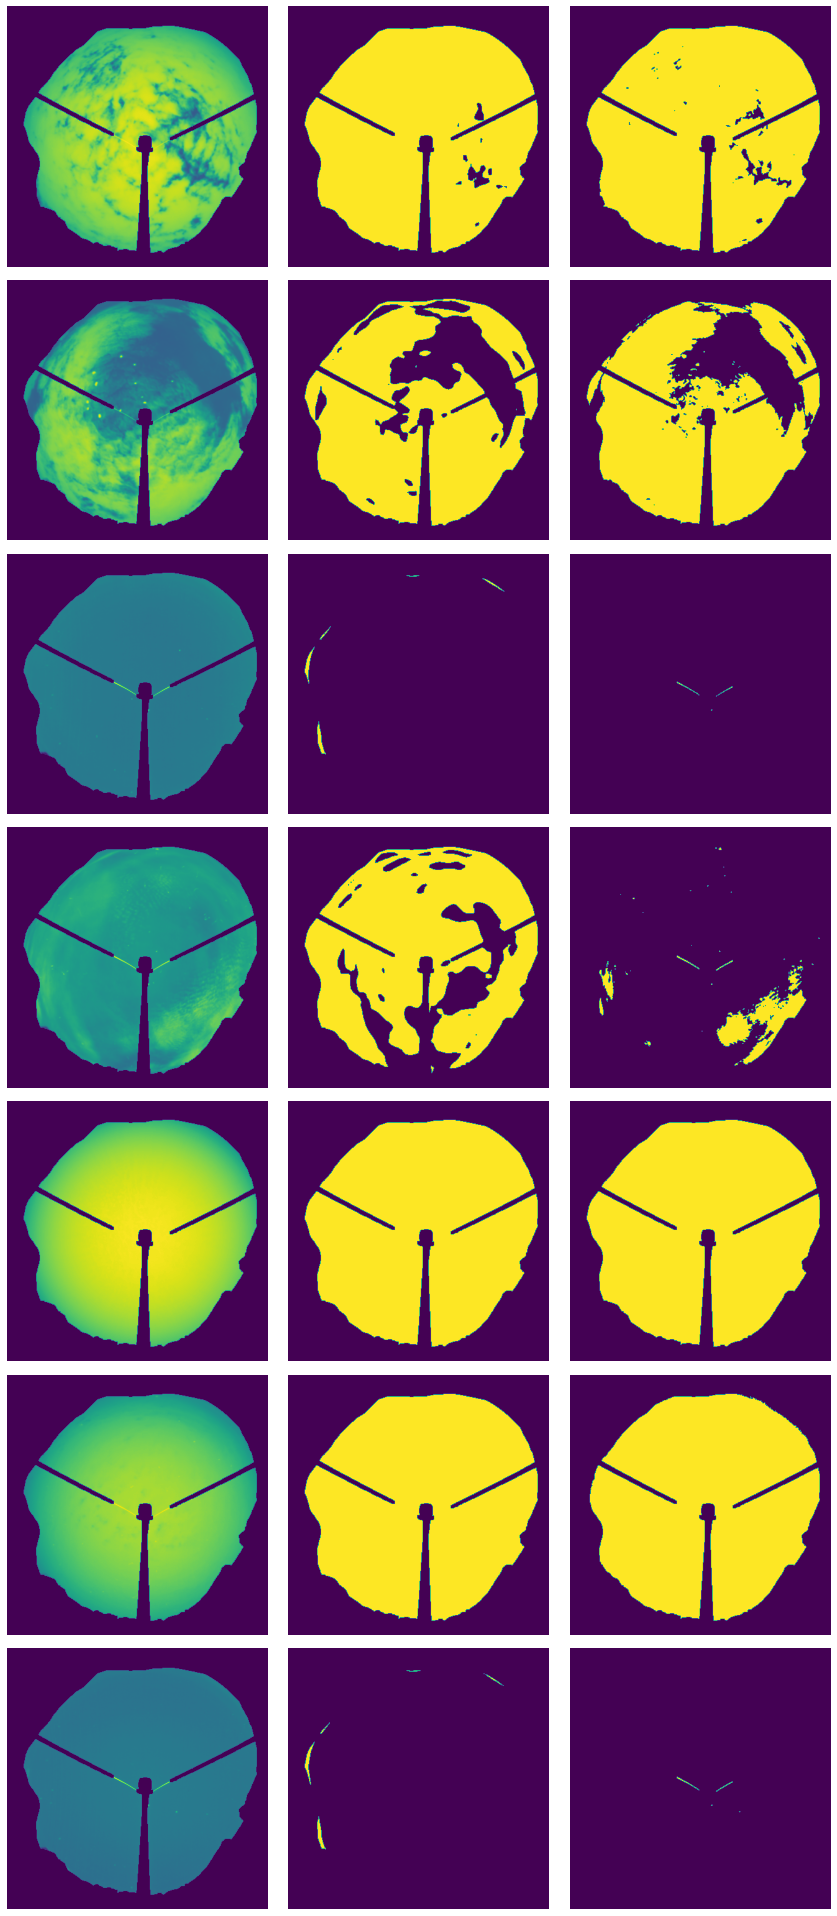

In [ ]:
plot_results(results)